# Lab Deteksi Wajah Penglihatan Komputer - Notebook Siswa

Di lab ini, Anda akan menggunakan Amazon Rekognition untuk melakukan deteksi wajah pada wajah yang dikenal.

Langkah tingkat tinggi yang akan Anda lakukan di lab ini adalah:

1. Buat koleksi.

2. Unggah citra wajah yang ingin Anda deteksi ke notebook Amazon SageMaker.

3. Tambahkan citra ke koleksi.

4. Lihat kotak batas yang dibuat untuk citra.

5. Daftar wajah dalam koleksi.

6. Gunakan koleksi untuk menemukan wajah.

7. Lihat kotak pembatas wajah yang ditemukan.

8. Hapus koleksi.

---

## Mengimpor paket Python

Mulailah dengan mengimpor paket Python yang Anda butuhkan.

Dalam kode berikut:

- *matplotlib* menyediakan fungsi perencanaan
- *skimage* mewakili scikit-image, yang menyediakan beberapa alat manipulasi gambar yang berguna
- *boto3* mewakili AWS SDK for Python (Boto3), yang merupakan pustaka Python untuk AWS
- *numpy* mewakili NumPy, yang merupakan pustaka untuk memanipulasi data
- *PIL* mewakili Python Imaging Library, yang berisi satu set alat untuk menggambar citra


In [45]:
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt

import boto3

import numpy as np

from PIL import Image, ImageDraw, ImageColor, ImageOps


## Tugas 1: Membuat koleksi

Dalam tugas ini, Anda membuat koleksi di Amazon Rekognition.

Anda hanya perlu menjalankan langkah ini sekali.


In [56]:
client = boto3.client('rekognition')
collection_id = 'Collection'
response = client.create_collection(CollectionId=collection_id)
print('Collection ARN: ' + response['CollectionArn'])
print('Status Code:' + str(response['StatusCode']))
print('Done...')

Collection ARN: aws:rekognition:us-east-1:396042991091:collection/Collection
Status Code:200
Done...


## Tugas 2: Mengunggah citra yang akan dicari

Gunakan citra contoh yang disediakan, yang bernama *mum.jpg*, dan unggah citra tersebut ke notebook ini.

Kemudian, lihat citra dengan menjalankan sel.


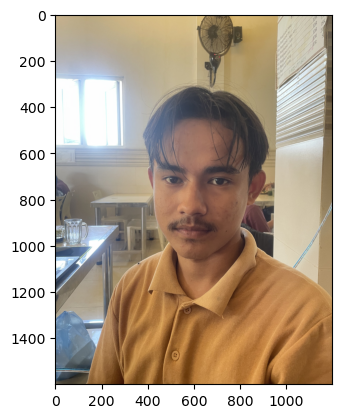

In [55]:
filename = "fajar.jpg"

faceimage = rescale(faceimage, 0.50, mode='constant')

faceimage = io.imread(filename)

plt.imshow(faceimage)



Pastikan bahwa ukuran citra kurang dari 4096 x 4096 piksel. Jika citra lebih besar dari ukuran ini, maka Anda harus mengubah ukurannya dengan menggunakan kode berikut:

`faceimage = rescale(faceimage, 0.50, mode='constant')`

**Catatan:** Nilai numerik mewakili faktor yang akan diskalakan. Nilai *0,5* akan menskalakan citra menjadi 50 persen dari aslinya.

Saat citra diubah ukurannya, simpan file.

`io.imsave(filename, faceimage)`

**Tips:** Anda harus menyalin kode ke dalam sel kode dan menjalankannya.


## Tugas 3: Menambahkan citra ke koleksi

Tambahkan citra ke koleksi yang Anda buat sebelumnya.


In [57]:
externalimageid = filename

with open(filename, 'rb') as fimage:
    response = client.index_faces(CollectionId = collection_id,
                             Image={'Bytes': fimage.read()},
                             ExternalImageId=externalimageid,
                             MaxFaces=1,
                             QualityFilter="AUTO",
                             DetectionAttributes=['ALL'])

print('Results for ' + filename)
print('Faces indexed:')
for faceRecord in response['FaceRecords']:
     print('  Face ID: ' + faceRecord['Face']['FaceId'])
     print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

print('Faces not indexed:')
for unindexedFace in response['UnindexedFaces']:
    print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
    print(' Reasons:')
    for reason in unindexedFace['Reasons']:
        print('   ' + reason)

Results for fajar.jpg
Faces indexed:
  Face ID: 408e3733-720d-4395-bd13-983bfa49e698
  Location: {'Width': 0.35563308000564575, 'Height': 0.3836394250392914, 'Left': 0.35153040289878845, 'Top': 0.28391194343566895}
Faces not indexed:


## Tugas 4: Melihat kotak pembatas untuk wajah yang terdeteksi

Jika wajah ditemukan, hasilnya harus mencakup lokasi wajah yang terdeteksi. Periksa kotak pembatas pada citra.

Untuk melakukannya, gunakan pustaka PIL, yang Anda impor sebelumnya di lab ini. Dengan mengekstrak BoundingBox, Anda dapat menggambar satu set garis di sekitar citra.


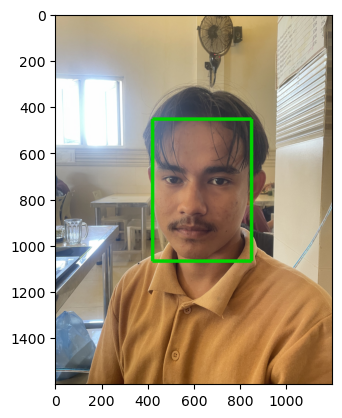

In [49]:

img = Image.open(filename)
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img)
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top))

    draw.line(points,fill='#00d400', width=15)
    
plt.imshow(img)

## Tugas 5: Daftar wajah dalam koleksi

Periksa citra yang Anda miliki dalam koleksi. 



In [58]:
maxResults=2
faces_count=0
tokens=True

response=client.list_faces(CollectionId=collection_id,
                           MaxResults=maxResults)

print('Faces in collection ' + collection_id)

while tokens:

    faces=response['Faces']

    for face in faces:
        print (face)
        faces_count+=1
    if 'NextToken' in response:
        nextToken=response['NextToken']
        response=client.list_faces(CollectionId=collection_id,
                                   NextToken=nextToken,MaxResults=maxResults)
    else:
        tokens=False

Faces in collection Collection
{'FaceId': '408e3733-720d-4395-bd13-983bfa49e698', 'BoundingBox': {'Width': 0.3556329905986786, 'Height': 0.38363900780677795, 'Left': 0.351529985666275, 'Top': 0.2839120030403137}, 'ImageId': '04a614e6-138a-3ac1-9e54-952363908459', 'ExternalImageId': 'fajar.jpg', 'Confidence': 99.99949645996094, 'IndexFacesModelVersion': '7.0'}


## Tugas 6: Menemukan wajah dengan menggunakan koleksi

Pada langkah ini, Anda akan menggunakan koleksi untuk mendeteksi wajah dalam citra.

Gunakan gambar contoh yang tersedia yang bernama *target.jpg* dan unggah ke notebook ini.



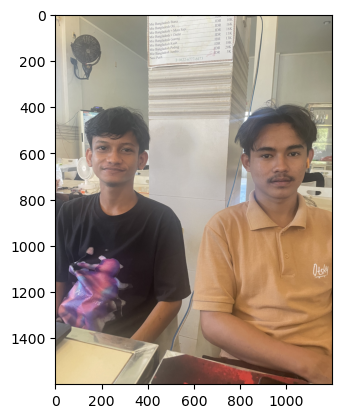

In [51]:
targetfilename = "target.jpg"

targetimage = Image.open(targetfilename)
plt.imshow(targetimage)

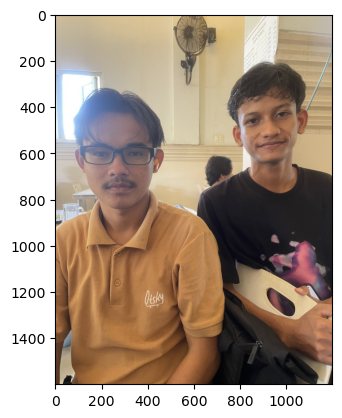

In [41]:
targetfilename = "target2.jpg"

targetimage = Image.open(targetfilename)
plt.imshow(targetimage)

Selanjutnya, panggil operasi `search_faces_by_image` dan lihat apakah Anda mendapatkan kecocokan.

In [59]:
threshold = 70
maxFaces=2

with open(targetfilename, 'rb') as timage:        
    response2=client.search_faces_by_image(CollectionId=collection_id,
                            Image={'Bytes': timage.read()},
                            FaceMatchThreshold=threshold,
                            MaxFaces=maxFaces)

faceMatches=response2['FaceMatches']
print ('Matching faces')
for match in faceMatches:
        print ('FaceId:' + match['Face']['FaceId'])
        print ('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
        print ('ExternalImageId: ' + match['Face']['ExternalImageId'])
        print

Matching faces
FaceId:408e3733-720d-4395-bd13-983bfa49e698
Similarity: 100.00%
ExternalImageId: fajar.jpg


## Tugas 7: Menggambar kotak pembatas di sekitar wajah yang ditemukan

Gambarlah kotak pembatas di sekitar wajah yang ditemukan.

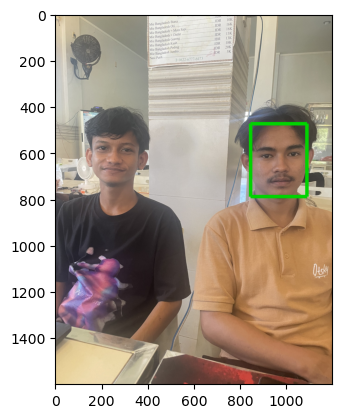

In [60]:
imgWidth, imgHeight = targetimage.size

draw = ImageDraw.Draw(targetimage)

box = response2['SearchedFaceBoundingBox']
left = imgWidth * box['Left']
top = imgHeight * box['Top']
width = imgWidth * box['Width']
height = imgHeight * box['Height']

points = ((left,top),(left+width,top),(left+width,top+height),(left,top+height),(left,top))
draw.line(points,fill='#00d400', width=15)
    
plt.imshow(targetimage)

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

NameError: name 'df_confusion' is not defined

## Tugas 8: Menghapus koleksi

Setelah selesai, hapus koleksi. Untuk melakukannya, jalankan kode berikut ini: 


In [54]:
print('Attempting to delete collection ' + collection_id)
status_code=0
try:
    response=client.delete_collection(CollectionId=collection_id)
    status_code=response['StatusCode']
    print('All done!')
    print(status_code)
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFoundException':
        print ('The collection ' + collection_id + ' was not found ')
    else:
        print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
    status_code=e.response['ResponseMetadata']['HTTPStatusCode']



Attempting to delete collection Collection
All done!
200


# Selamat!

Anda telah menyelesaikan lab ini, dan sekarang Anda dapat mengakhirinya dengan mengikuti petunjuk panduan lab tersebut.